In [48]:
import json
from pprint import pprint
from collections import Counter
import re
import requests
import matplotlib.pyplot as plt
import time
import pandas as pd

with open("../public/ligifyDB.json", "r") as f:
    data = json.load(f)

# Count number of unique small molecules
unique_regs = len(data)
print(f"Unique regulators: {unique_regs}")

# Extract SMILES strings
smiles_list = []
for entry in data:
    if "candidate_ligands" in entry:
        for ligand in entry["candidate_ligands"]:
            if "smiles" in ligand:
                smiles_list.append(ligand["smiles"])

# Convert to DataFrame for convenience
df = pd.DataFrame(smiles_list, columns=["SMILES"])

# Count unique SMILES
unique_smiles = df["SMILES"].nunique()

print(f"Total SMILES entries: {len(df)}")
print(f"Unique SMILES entries: {unique_smiles}")

    

Unique regulators: 3164
Total SMILES entries: 18898
Unique SMILES entries: 1374


START OF THE ORGANISM SECTION

{'Actinomycetota': 434, 'Bacillota': 527, 'Pseudomonadota': 1594, 'Verrucomicrobiota': 9, 'Bacteroidota': 60, 'Myxococcota': 34, 'Elusimicrobiota': 3, 'Chloroflexota': 49, 'Deinococcota': 48, 'Cyanobacteriota': 68, 'Fusobacteriota': 12, 'Thermotogota': 47, 'Aquificota': 23, 'Mycoplasmatota': 19, 'Spirochaetota': 27, 'Thermomicrobiota': 4, 'Thermodesulfobacteriota': 124, 'Nitrospirota': 5, 'Acidobacteriota': 9, 'Chlamydiota': 3, 'Campylobacterota': 25, 'Dictyoglomota': 3, 'Bdellovibrionota': 5, 'Rhodothermota': 8, 'Chlorobiota': 11, 'Coprothermobacterota': 3, 'Fibrobacterota': 1, 'Planctomycetota': 5, 'Deferribacterota': 1, 'Gemmatimonadota': 3}
{'Other': 609, 'Actinomycetota': 434, 'Bacillota': 527, 'Pseudomonadota': 1594}


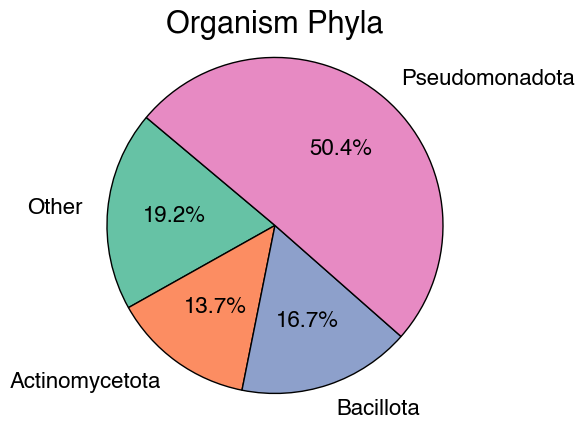

In [204]:
# DISTRIBUTION OF ORGANISM PHYLA

phyla_dict = {}

for i in data:
    phyla = i['protein']['organism'][2]
    if phyla in phyla_dict:
        phyla_dict[phyla] += 1
    else:
        phyla_dict[phyla] = 1

print(phyla_dict)

# group all minor phyla into an "other" category
phyla_dict2 = {"Other": 0}
for i in phyla_dict:
    if phyla_dict[i] > 400:
        phyla_dict2[i] = phyla_dict[i]
    else:
        phyla_dict2["Other"] += phyla_dict[i]

print(phyla_dict2)


# # Data for the pie chart
sizes = [i for i in phyla_dict2.values()]  
labels = [i for i in phyla_dict2.keys()]
colors = plt.cm.Set2.colors[:len(sizes)]


# # custom function for autopct font size
def make_autopct(values):
    def my_autopct(pct):
        return f"{pct:.1f}%"  # format
    return my_autopct

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct=make_autopct(sizes),
    startangle=140,
    colors=colors,
    wedgeprops={"edgecolor": "black", "linewidth": 1},
    textprops={"fontweight": "bold", "fontsize": 16},  # labels
    labeldistance=1.15,   # <— move labels inside (default = 1.1)
    pctdistance=0.6     # <— move numbers further inside
)

# make autopct (numbers) bigger
for autotext in autotexts:
    # autotext.set_fontsize(20)   # bigger font
    autotext.set_weight("bold") # optional bold

plt.title("Organism Phyla", fontsize=22, weight="bold")
plt.axis("equal")

# # Save as PNG directly into the public folder
plt.savefig("../public/Content_Stats/Organism_Phyla.png", format="png", dpi=500)

plt.show()

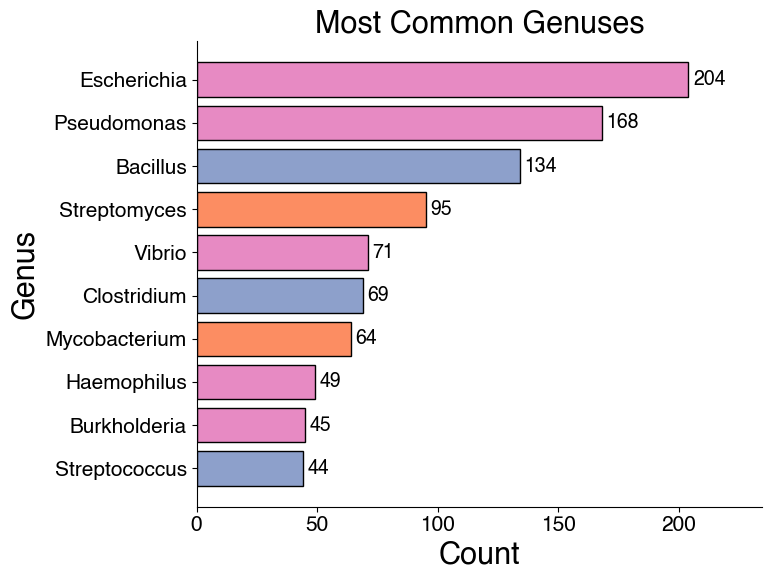

In [203]:
# TOP 10 MOST COMMON ORGANISMS

genus_dict = {}

for i in data:
    try:
        genus = i['protein']['organism'][6]
        if genus in genus_dict:
            genus_dict[genus] += 1
        else:
            genus_dict[genus] = 1
    except: 
        pass

genus_dict = sorted(genus_dict.items(), key=lambda kv: kv[1], reverse=True)

genus_dict10 = dict(genus_dict[0:10])

# Extract keys and values
names = list(genus_dict10.keys())
values = list(genus_dict10.values())

# Colors:
colors = []
Other = (0.4, 0.7607843137254902, 0.6470588235294118)
Actinomycetota = (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)
Bacillota = (0.5529411764705883, 0.6274509803921569, 0.796078431372549)
Pseudomonadota = (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)

sss = ['Escherichia', 'Pseudomonas', 'Bacillus', 'Streptomyces', 'Vibrio', 'Clostridium', 'Mycobacterium', 'Haemophilus', 'Burkholderia', 'Streptococcus']
for i in names:
    # Other
    if i in []:
        colors.append(Other)
    # Actinomycetota
    elif i in ['Streptomyces', 'Mycobacterium', ]:
        colors.append(Actinomycetota)
    # Bacillota
    elif i in ['Bacillus', 'Clostridium', 'Streptococcus']:
        colors.append(Bacillota)
    # Pseudomonadota
    elif i in ['Escherichia', 'Pseudomonas', 'Vibrio', 'Haemophilus', 'Burkholderia']:
        colors.append(Pseudomonadota)

# Modern font settings
plt.rcParams.update({
    "font.family": "Helvetica",  # swap with "Helvetica" if available
    # "font.size": 13
})




# Plot
plt.figure(figsize=(8,6))
bars = plt.barh(names, values, color=colors, edgecolor="black")  # add black outline

plt.xlabel("Count", fontsize=22, fontweight="bold")
plt.ylabel("Genus", fontsize=22, fontweight="bold")
plt.title("Most Common Genuses", fontsize=22, fontweight="bold")

# Increase tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Add value labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 2,              # shift a little right of the bar
             bar.get_y() + bar.get_height()/2,
             str(width),
             va="center", ha="left", fontsize=14, weight="bold")

# Remove top and right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.gca().invert_yaxis()  # largest on top
plt.tight_layout()

ax = plt.gca()
ax.margins(x=0.15)  # 15% extra room on the x-axis

# Save as PNG directly into the public folder
plt.savefig("../public/Content_Stats/Common_Genuses.png", format="png", dpi=500)

plt.show()

START OF THE REGULATOR SECTION

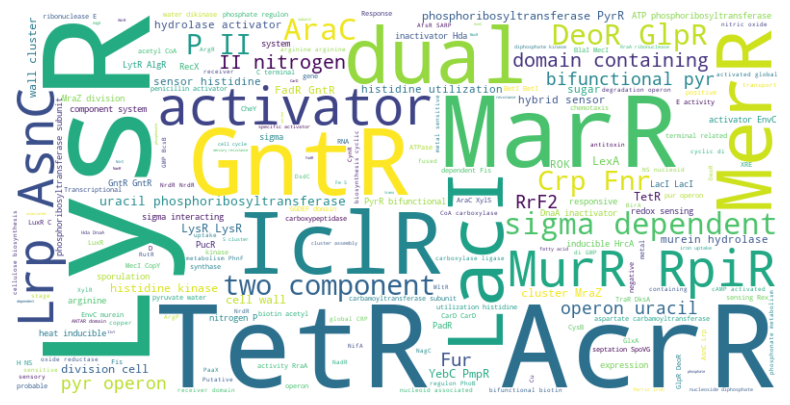

In [24]:
# CREATE A WORD CLOUD FROM ANNOTATIONS

# Get all regulators annotations
annotations = [i["annotation"] for i in data]

# Extract and count all the “words”
words = [
    w
    for ann in annotations
    for w   in re.findall(r'\b\w+\b', ann)
]
counts = Counter(words)

# Combine all individual annotation words into one string, and remove non-descriptive labels
annos = "".join(i+" " for i in words if i not in ["transcriptional", "regulator", "family", "transcription", "factor", "DNA", "response", "helix",\
    "regulatory", "protein", "repressor", "binding", "putative", "winged", "HTH", "type", "turn"])


# # Make a word cloud
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(annos)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off") # Turn off axis labels
plt.show()


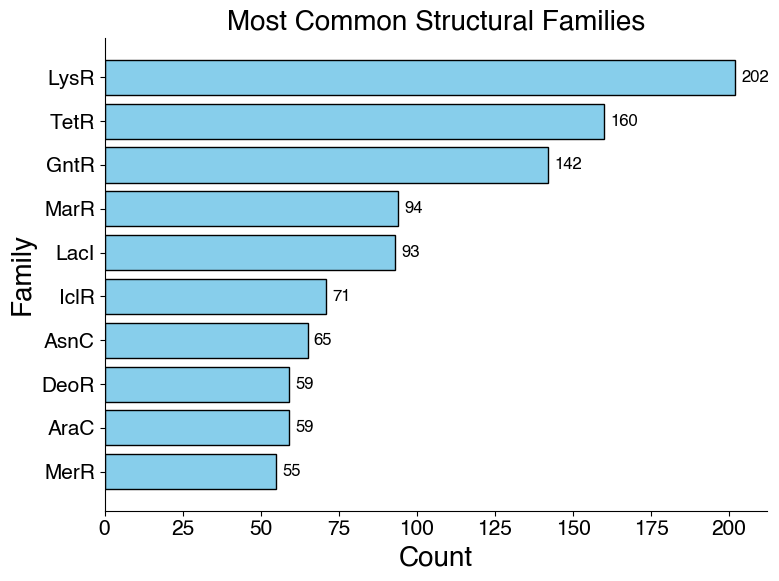

In [46]:
# CREATE A BAR PLOT WITH MOST COMMON FAMILIES

# created from filtering 
families = {
    'LysR': 202, 'TetR': 160, 'GntR': 142, 'MarR': 94, 'LacI': 93, 'IclR': 71, 'AsnC': 65, 'DeoR': 59, 'AraC': 59, 'MerR': 55
    }

# Sort dictionary (optional, for cleaner plot)
sorted_data = dict(sorted(families.items(), key=lambda x: x[1], reverse=True))

# Extract keys and values
names = list(sorted_data.keys())
values = list(sorted_data.values())

# Modern font settings
plt.rcParams.update({
    "font.family": "Helvetica",  # swap with "Helvetica" if available
    "font.size": 13
})

# Plot
plt.figure(figsize=(8,6))
bars = plt.barh(names, values, color="skyblue", edgecolor="black")  # add black outline

plt.xlabel("Count", fontsize=20, fontweight="bold")
plt.ylabel("Family", fontsize=20, fontweight="bold")
plt.title("Most Common Structural Families", fontsize=20, fontweight="bold")

# Increase tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Add value labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 2,              # shift a little right of the bar
             bar.get_y() + bar.get_height()/2,
             str(width),
             va="center", ha="left", fontsize=12, weight="bold")

# Remove top and right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.gca().invert_yaxis()  # largest on top
plt.tight_layout()

# Save as PNG directly into the public folder
plt.savefig("../public/Content_Stats/Common_Families.png", format="png", dpi=500)

plt.show()

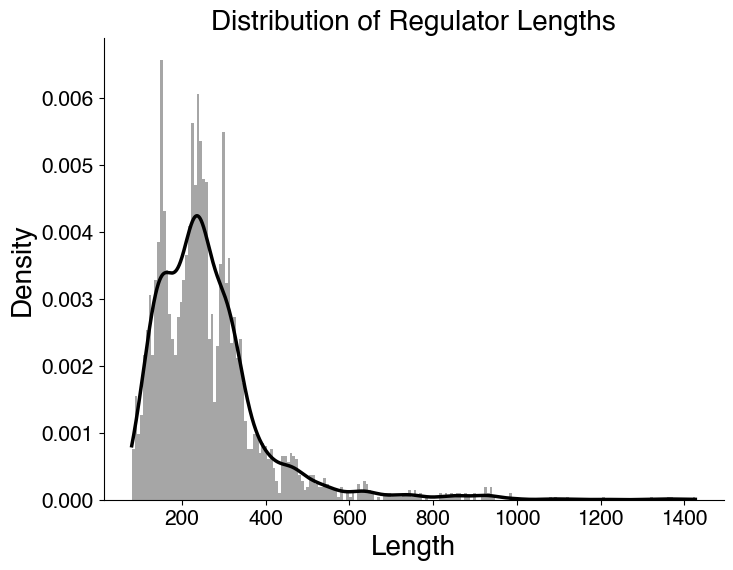

In [47]:
# HISTOGRAM DISTRIBUTION OF REGULATOR LENGTHS

import numpy as np
from scipy.stats import gaussian_kde

# get lengths
reg_lengths = [len(i["protein_seq"]) for i in data]

# Convert to numpy array
reg_lengths = np.array(reg_lengths)

# Fit Gaussian KDE
kde = gaussian_kde(reg_lengths)
x_vals = np.linspace(reg_lengths.min(), reg_lengths.max(), 10000)  # smooth x range
y_vals = kde(x_vals)

# Modern font settings
plt.rcParams.update({
    "font.family": "Helvetica",  # swap with "Helvetica" if available
    "font.size": 13
})

# Plot
plt.figure(figsize=(8,6))

# Plot smooth KDE curve
plt.plot(x_vals, y_vals, color="black", linewidth=2.5)

# Optionally also plot the histogram as background
plt.hist(reg_lengths, bins=200, color="gray", density=True, alpha=0.7)

plt.xlabel('Length', fontsize=20, fontweight="bold")
plt.ylabel('Density', fontsize=20, fontweight="bold")
plt.title("Distribution of Regulator Lengths", fontsize=20, fontweight="bold")

# Increase tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Remove top and right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Save as PNG directly into the public folder
plt.savefig("../public/Content_Stats/Regulator_Lengths.png", format="png", dpi=500)

plt.show()

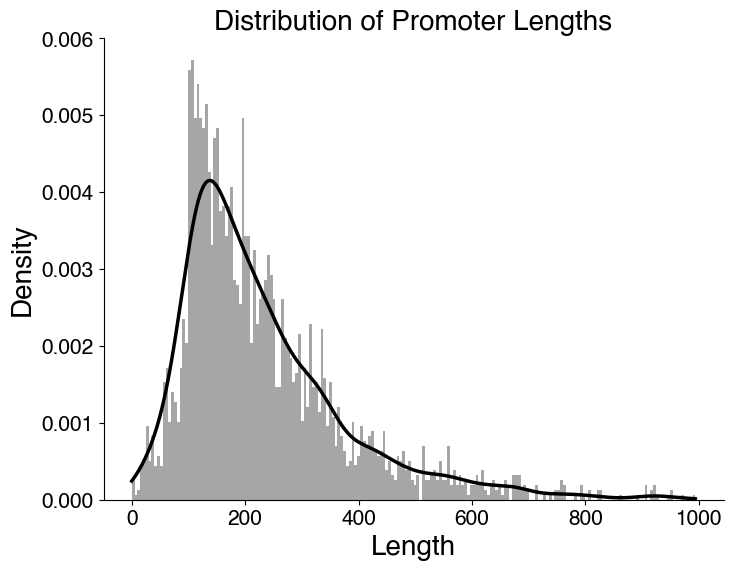

In [194]:
# LENGTH OF PREDICTED PROMOTER

promoter_lengths = [len(i['protein']['context']['promoter']["regulated_seq"]) for k in data for i in k['data'][0]]

# Create a new figure
plt.figure()                      
plt.hist(promoter_lengths, bins=100, density=True)
plt.xlabel('Predicted promoter length')
plt.ylabel('Density')
plt.title('Lengths of predicted promoters')
plt.show()

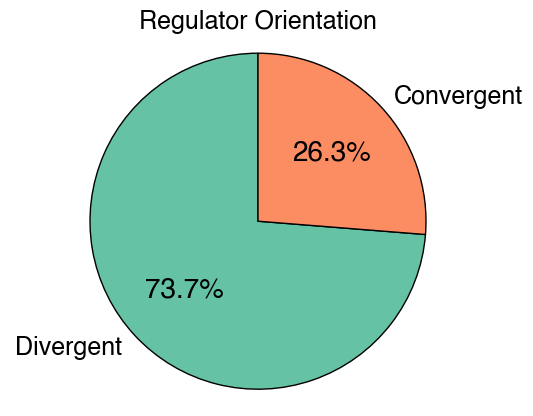

In [74]:
# DIRECTION OF REGULATOR EXPRESSION

reg_direction = [i['protein']['context']['promoter']["reg_type"] for i in data]


total = len(reg_direction)
divergent = int((len([i for i in reg_direction if i == 1])/total)*100)
convergent = int((len([i for i in reg_direction if i == 2])/total)*100)

# Data for the pie chart
sizes = [divergent, convergent]  
labels = ['Divergent', 'Convergent']
colors = plt.cm.Set2.colors[:2]

# custom function for autopct font size
def make_autopct(values):
    def my_autopct(pct):
        return f"{pct:.1f}%"  # format
    return my_autopct

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct=make_autopct(sizes),
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor": "black", "linewidth": 1},
    textprops={"fontweight": "bold", "fontsize": 18}  # labels
)

# make autopct (numbers) bigger
for autotext in autotexts:
    autotext.set_fontsize(20)   # bigger font
    autotext.set_weight("bold") # optional bold

plt.title("Regulator Orientation", fontsize=18, weight="bold")
plt.axis("equal")

# Save as PNG directly into the public folder
plt.savefig("../public/Content_Stats/Regulator_Orientation.png", format="png", dpi=500)

plt.show()

START OF LIGAND SECTION

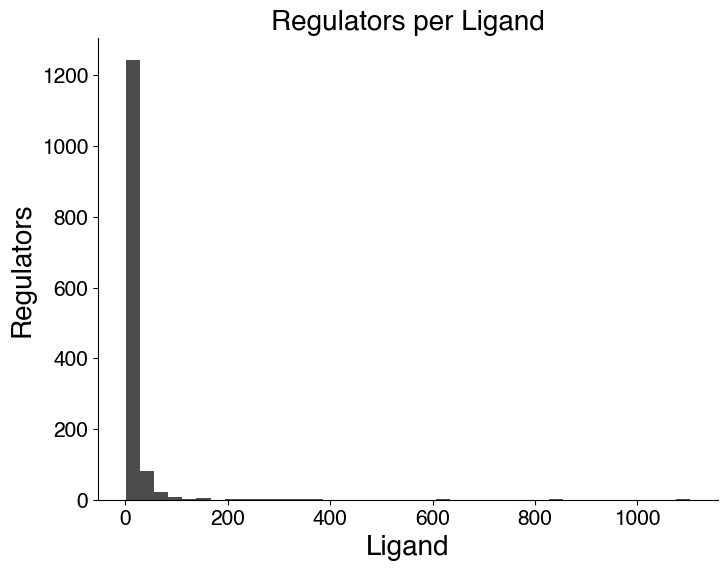

In [180]:
# HISTOGRAM DISTRIBUTION OF REGULATORS PER LIGAND

# create ligand dict
ligands = {}
for i in data:
    for l in i["candidate_ligands"]:
        if l['name'] not in ligands:
            ligands[l['name']] = 1
        else:
            ligands[l['name']] += 1


liglist = [ligands[i] for i in ligands]

# Convert to numpy array
liglist = np.array(liglist)

# Fit Gaussian KDE
kde = gaussian_kde(liglist)
x_vals = np.linspace(liglist.min(), liglist.max(), 10000)  # smooth x range
y_vals = kde(x_vals)

# Modern font settings
plt.rcParams.update({
    "font.family": "Helvetica",  # swap with "Helvetica" if available
    "font.size": 13
})

# Plot
plt.figure(figsize=(8,6))

# Plot smooth KDE curve
# plt.plot(x_vals, y_vals, color="black", linewidth=2.5)

# Optionally also plot the histogram as background
plt.hist(liglist, bins=40, color="black", alpha=0.7)

plt.xlabel('Ligand', fontsize=20, fontweight="bold")
plt.ylabel('Regulators', fontsize=20, fontweight="bold")
plt.title("Regulators per Ligand", fontsize=20, fontweight="bold")

# Increase tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Remove top and right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Save as PNG directly into the public folder
plt.savefig("../public/Content_Stats/RegulatorsPerLigand.png", format="png", dpi=500)

plt.show()

434


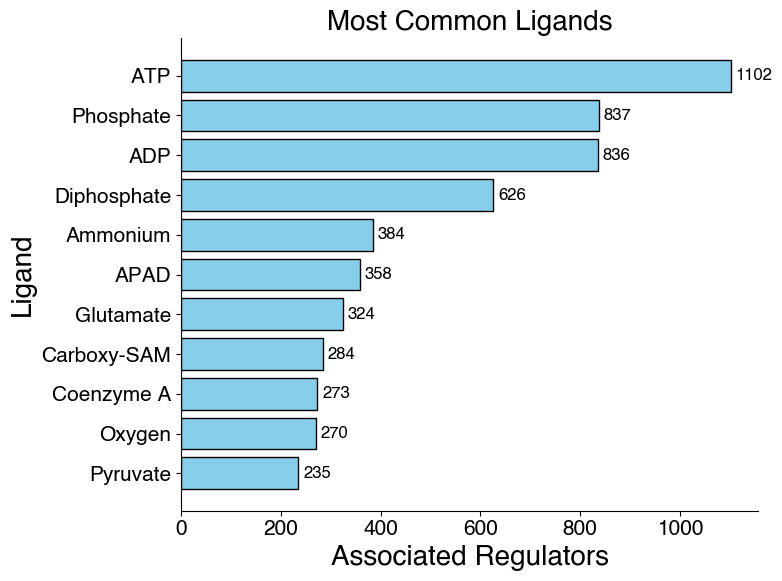

In [198]:

# Sort dictionary
sorted_data = dict(sorted(ligands.items(), key=lambda x: x[1], reverse=True))

c = 0
for i in sorted_data:
    if sorted_data[i] == 1:
        c += 1
print(c)

# Manually create a dictionary with the top 10 ligands, using their common names
clean_ligdict = {
    'ATP': 1102, 
    'Phosphate': 837, 
    'ADP': 836,
    'Diphosphate': 626, 
    'Ammonium': 384, 
    'APAD': 358, 
    'Glutamate': 324, 
    'Carboxy-SAM': 284, 
    'Coenzyme A': 273, 
    'Oxygen': 270, 
    'Pyruvate': 235
}

# Extract keys and values
names = list(clean_ligdict.keys())
values = list(clean_ligdict.values())

# Modern font settings
plt.rcParams.update({
    "font.family": "Helvetica",  # swap with "Helvetica" if available
    "font.size": 13
})

# Plot
plt.figure(figsize=(8,6))
bars = plt.barh(names, values, color="skyblue", edgecolor="black")  # add black outline

plt.xlabel("Associated Regulators", fontsize=20, fontweight="bold")
plt.ylabel("Ligand", fontsize=20, fontweight="bold")
plt.title("Most Common Ligands", fontsize=20, fontweight="bold")

# Increase tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Add value labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 10,              # shift a little right of the bar
             bar.get_y() + bar.get_height()/2,
             str(width),
             va="center", ha="left", fontsize=12, weight="bold")

# Remove top and right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.gca().invert_yaxis()  # largest on top
plt.tight_layout()

# Save as PNG directly into the public folder
plt.savefig("../public/Content_Stats/Top10-Ligands.png", format="png", dpi=500)

plt.show()

START OF THE RANKING SECTION

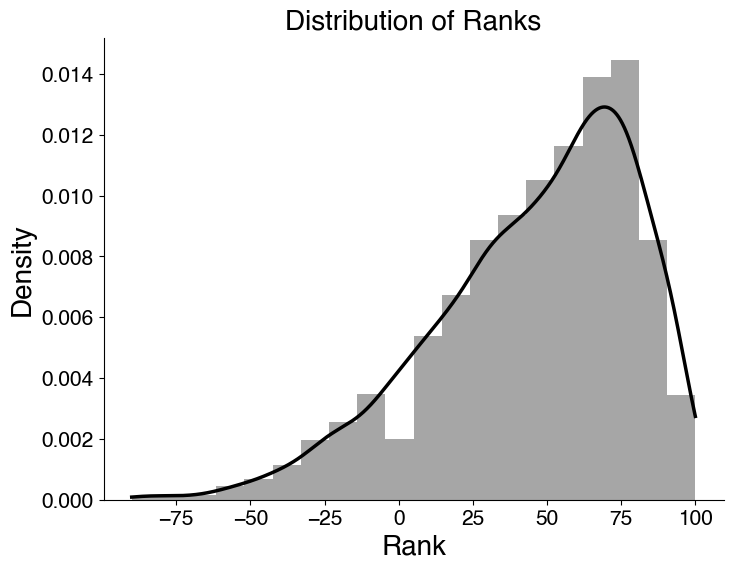

In [131]:

# RANK

rank = [i['rank']['rank'] for i in data]

# Convert to numpy array
rank = np.array(rank)

# Fit Gaussian KDE
kde = gaussian_kde(rank)
x_vals = np.linspace(rank.min(), rank.max(), 10000)  # smooth x range
y_vals = kde(x_vals)

# Modern font settings
plt.rcParams.update({
    "font.family": "Helvetica",  # swap with "Helvetica" if available
    "font.size": 13
})

# Plot
plt.figure(figsize=(8,6))

# Plot smooth KDE curve
plt.plot(x_vals, y_vals, color="black", linewidth=2.5)

# Optionally also plot the histogram as background
plt.hist(rank, bins=20, color="gray", density=True, alpha=0.7)

plt.xlabel('Rank', fontsize=20, fontweight="bold")
plt.ylabel('Density', fontsize=20, fontweight="bold")
plt.title("Distribution of Ranks", fontsize=20, fontweight="bold")

# Increase tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Remove top and right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Save as PNG directly into the public folder
plt.savefig("../public/Content_Stats/Ranks.png", format="png", dpi=500)

plt.show()



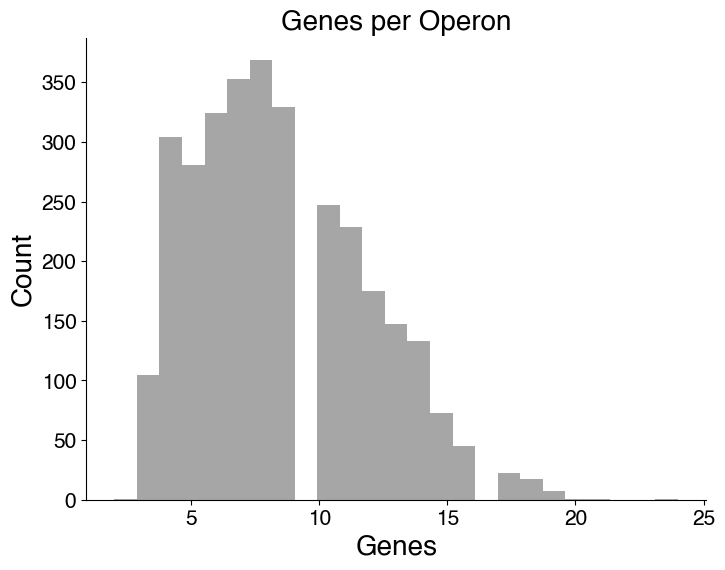

In [162]:
# NUMBER OF GENES PER OPERON

genes = [i['rank']['metrics']['Genes within operon']['Value'] for i in data]

# Convert to numpy array
genes = np.array(genes)

# Fit Gaussian KDE
kde = gaussian_kde(genes)
x_vals = np.linspace(genes.min(), genes.max(), 10000)  # smooth x range
y_vals = kde(x_vals)

# Modern font settings
plt.rcParams.update({
    "font.family": "Helvetica",  # swap with "Helvetica" if available
    "font.size": 13
})

# Plot
plt.figure(figsize=(8,6))

# Plot smooth KDE curve
# plt.plot(x_vals, y_vals, color="black", linewidth=2.5)

# Also plot the histogram as background
plt.hist(genes, bins=25, color="gray", alpha=0.7)

plt.xlabel('Genes', fontsize=20, fontweight="bold")
plt.ylabel('Count', fontsize=20, fontweight="bold")
plt.title("Genes per Operon", fontsize=20, fontweight="bold")

# Increase tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Remove top and right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Save as PNG directly into the public folder
plt.savefig("../public/Content_Stats/GenesPerOperon.png", format="png", dpi=500)

plt.show()


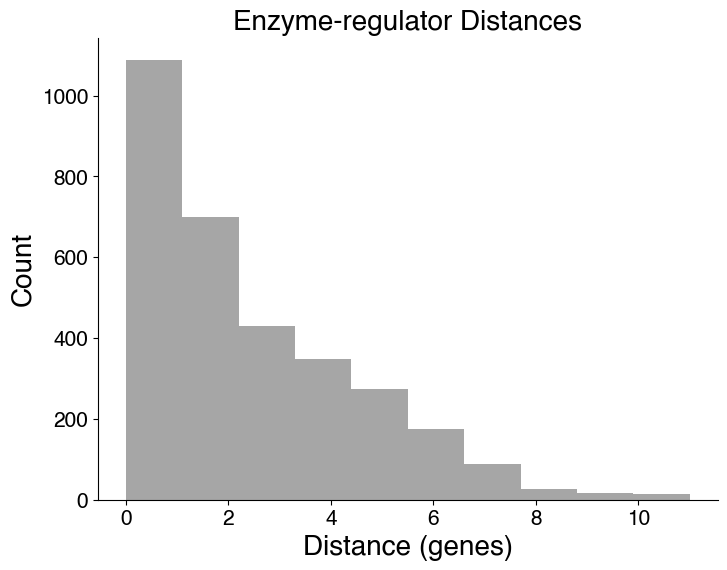

In [163]:
# ENZYME_REGULATOR DISTANCE OF GENES PER OPERON

Edistance = [i['rank']['metrics']['Enzyme-regulator distance']['Value'] for i in data]

# Convert to numpy array
Edistance = np.array(Edistance)

# Fit Gaussian KDE
kde = gaussian_kde(Edistance)
x_vals = np.linspace(Edistance.min(), Edistance.max(), 1000)  # smooth x range
y_vals = kde(x_vals)

# Modern font settings
plt.rcParams.update({
    "font.family": "Helvetica",  # swap with "Helvetica" if available
    "font.size": 13
})

# Plot
plt.figure(figsize=(8,6))

# Plot smooth KDE curve
# plt.plot(x_vals, y_vals, color="black", linewidth=2.5)

# Also plot the histogram as background
plt.hist(Edistance, color="gray", alpha=0.7)

plt.xlabel('Distance (genes)', fontsize=20, fontweight="bold")
plt.ylabel('Count', fontsize=20, fontweight="bold")
plt.title("Enzyme-regulator Distances", fontsize=20, fontweight="bold")

# Increase tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Remove top and right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Save as PNG directly into the public folder
plt.savefig("../public/Content_Stats/EnzymeDistance.png", format="png", dpi=500)

plt.show()

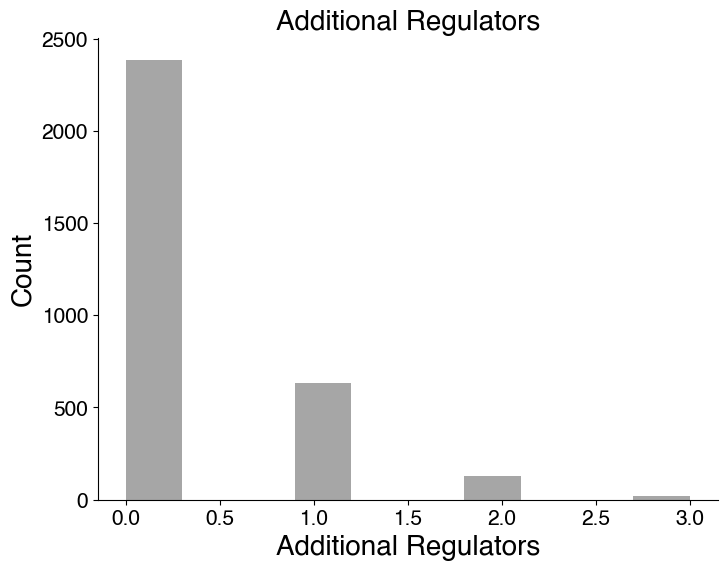

In [164]:
# NUMBER OF ADDITIONAL REGULATORS PER OPERON

addReg = [i['rank']['metrics']['Additional regulators']['Value'] for i in data]

# Convert to numpy array
addReg = np.array(addReg)

# Fit Gaussian KDE
kde = gaussian_kde(addReg)
x_vals = np.linspace(addReg.min(), addReg.max(), 1000)  # smooth x range
y_vals = kde(x_vals)

# Modern font settings
plt.rcParams.update({
    "font.family": "Helvetica",  # swap with "Helvetica" if available
    "font.size": 13
})

# Plot
plt.figure(figsize=(8,6))

# Plot smooth KDE curve
# plt.plot(x_vals, y_vals, color="black", linewidth=2.5)

# Also plot the histogram as background
plt.hist(addReg, color="gray", alpha=0.7)

plt.xlabel('Additional Regulators', fontsize=20, fontweight="bold")
plt.ylabel('Count', fontsize=20, fontweight="bold")
plt.title("Additional Regulators", fontsize=20, fontweight="bold")

# Increase tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Remove top and right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Save as PNG directly into the public folder
plt.savefig("../public/Content_Stats/AltRegulators.png", format="png", dpi=500)

plt.show()

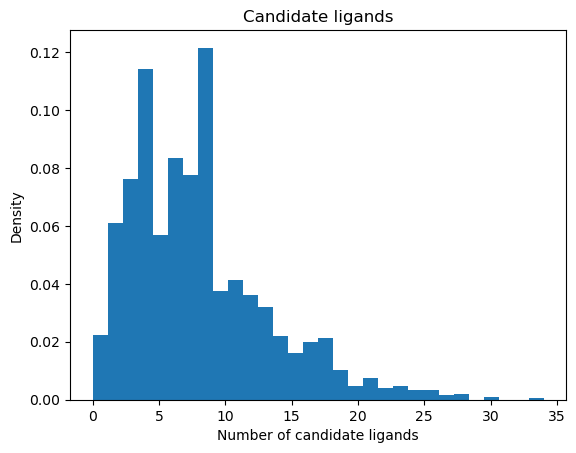

In [30]:
# Number of candidate ligands

candidate_ligands = [len(i["candidate_ligands"]) for k in data for i in k['data'][0]]

# Create a new figure
plt.figure()                      
plt.hist(candidate_ligands, bins=30, density=True)
plt.xlabel('Number of candidate ligands')
plt.ylabel('Density')
plt.title('Candidate ligands')
plt.show()